Load the Libraries

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [18]:
cudnn.benchmark = True
plt.ion()

Loading the Dataset

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
data_dir = '/content/drive/MyDrive/ML Class/Project 1/Animals'

Data Transformation

In [21]:
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder( data_dir , transform=data_transforms)

train_size = int(0.8*len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}


dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

class_names = full_dataset.classes

In [22]:
model_ft = models.resnet18(weights ='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,3)


In [23]:
class_names = full_dataset.classes
print(class_names)

['cats', 'dogs', 'snakes']


In [24]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available()else "cpu"
print(f"Using {device} device")

Using cuda device


Verify the Loading

In [25]:
def imshow(inp, title=None):
  """Display images for Tensor"""
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = std * inp + mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

In [26]:
inputs, classes = next(iter(train_loader))


In [27]:
out = torchvision.utils.make_grid(inputs)

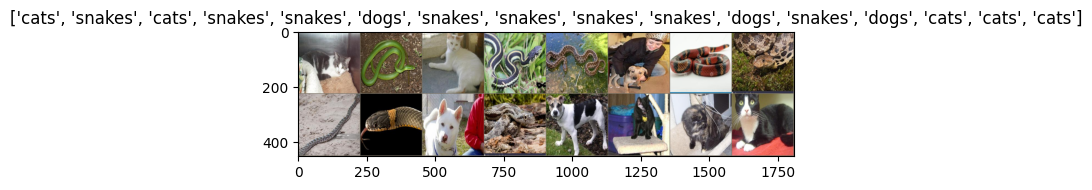

In [28]:
imshow(out, title = [class_names[x] for x in classes])

Training the Model

In [29]:
def train_model(model,dataloaders,criterion,optimizer,scheduler , num_epochs=4):
  since = time.time()

  best_model_parms_path = '/content/drive/MyDrive/ML Class/Project 1/Project One.pth'
  final_model_parms_path = '/content/drive/MyDrive/ML Class/Project 1/Project One.pth'

  torch.save(model.state_dict(), final_model_parms_path)
  best_acc = 0.0
  train_acc= 0.0
  val_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-'*10)

    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs,1)
          loss = criterion(outputs,labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase == 'train':
        train_acc = epoch_acc

      elif phase == 'val':
        val_acc = epoch_acc

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), best_model_parms_path)

    print()


  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Final Training Acc: {train_acc:.4f}')
  print(f'Final Validation Acc: {val_acc:.4f}')
  print(f'Best Validation Acc: {best_acc:.4f}')
  print(f'Model saved to:{best_model_parms_path} and {final_model_parms_path}')

  model.load_state_dict(torch.load(best_model_parms_path))
  return model

Visualizing the model prediction

In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
      for i,(inputs,labels) in enumerate((dataloaders['val'])):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _,preds = torch.max(outputs,1)

        for j in range(inputs.size()[0]):
          images_so_far += 1
          ax = plt.subplot(num_images//2,2,images_so_far)
          ax.axis('off')
          ax.set_title(f'predicted: {class_names[preds[j]]}')
          imshow(inputs.cpu().data[j])

          if images_so_far == num_images:
            model.train(mode=was_training)
            return

      model.train(mode=was_training)



Finetuning the CNN

In [31]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate

In [32]:
model_ft= train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 0.2030 Acc: 0.9229
val Loss: 0.0467 Acc: 0.9850

Epoch 1/3
----------
train Loss: 0.0612 Acc: 0.9792
val Loss: 0.0447 Acc: 0.9850

Epoch 2/3
----------
train Loss: 0.0377 Acc: 0.9896
val Loss: 0.0304 Acc: 0.9900

Epoch 3/3
----------
train Loss: 0.0221 Acc: 0.9946
val Loss: 0.0283 Acc: 0.9917

Training complete in 9m 29s
Final Training Acc: 0.9946
Final Validation Acc: 0.9917
Best Validation Acc: 0.9917
Model saved to:/content/drive/MyDrive/ML Class/Project 1/Project One.pth and /content/drive/MyDrive/ML Class/Project 1/Project One.pth


Visualize the Output

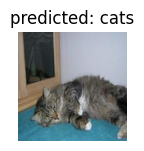

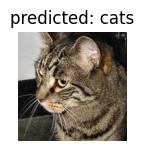

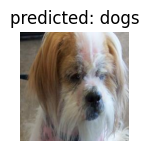

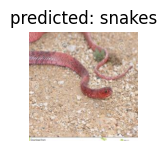

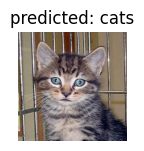

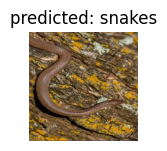

In [33]:
visualize_model(model_ft)

Transfer Learning

In [34]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

for parm in model_conv.parameters():
    parm.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs , 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate

In [35]:
model_conv = train_model(model_conv, dataloaders, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 0.2767 Acc: 0.9013
val Loss: 0.0730 Acc: 0.9800

Epoch 1/3
----------
train Loss: 0.1165 Acc: 0.9604
val Loss: 0.0698 Acc: 0.9783

Epoch 2/3
----------
train Loss: 0.1013 Acc: 0.9671
val Loss: 0.0490 Acc: 0.9867

Epoch 3/3
----------
train Loss: 0.0983 Acc: 0.9663
val Loss: 0.0452 Acc: 0.9850

Training complete in 1m 9s
Final Training Acc: 0.9663
Final Validation Acc: 0.9850
Best Validation Acc: 0.9867
Model saved to:/content/drive/MyDrive/ML Class/Project 1/Project One.pth and /content/drive/MyDrive/ML Class/Project 1/Project One.pth


Visualize the Output

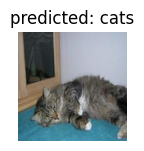

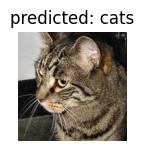

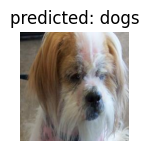

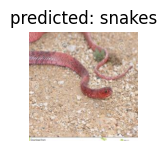

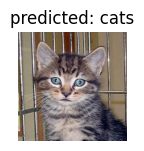

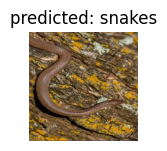

In [36]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference

In [37]:
def visualize_model_prediction(model , img_path):
  was_training = model.training
  model.eval()

  img = Image.open(img_path)
  img = data_transforms(img)
  img = img.unsqueeze(0)
  img = img.to(device)

  with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs,1)

    ax = plt.subplot()
    ax.axis('off')
    ax.set_title(f'predicted: {class_names[preds[0]]}')
    imshow(img.cpu().data[0])

    model.train(mode = was_training)

Get Predicton for Unseen Data

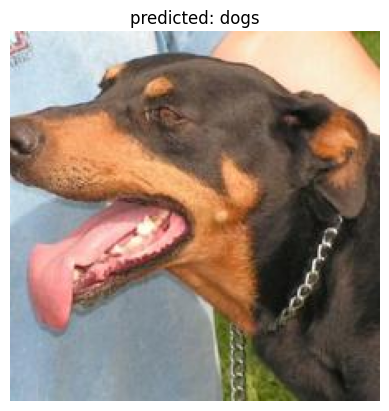

In [38]:
#Fine-tuned model
visualize_model_prediction(
    model_ft,
    img_path = '/content/drive/MyDrive/ML Class/Project 1/Animals/dogs/1_0005.jpg'
)

plt.ioff()
plt.show()

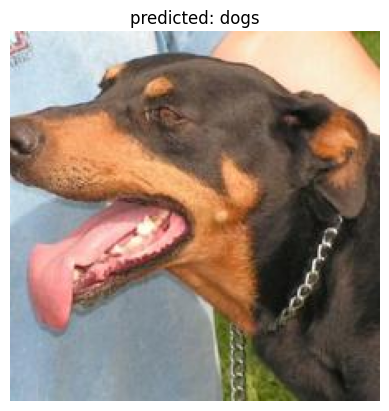

In [39]:
#Transfer Learning Model
visualize_model_prediction(
    model_conv,
    img_path = '/content/drive/MyDrive/ML Class/Project 1/Animals/dogs/1_0005.jpg'
)

plt.ioff()
plt.show()

Save the model weights

In [43]:
save_path = '/content/drive/MyDrive/ML Class/Project 1/Project One.pth'
torch.save(model_ft.state_dict(), save_path )